In [2]:
#import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
#solve the svm optimization problem, use cvxpy == 1.0.32 only
import cvxpy as optimizer

In [3]:
#load the iris dataset, it is a python dictionary
iris = datasets.load_iris()
#this converting is only for visualization purposes
iris_df = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
print(iris_df.head())
print(np.unique(iris.target))
print({0: "Iris-Setosa", 1: "Iris-Versicolour", 2:"Iris-Virginica" })

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
[0 1 2]
{0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}


In [4]:
#let us build a svm classifier between Iris Versicolor and Iris Virginica
#Task: Identify virginica from the rest based on  petal length (column 2) and petal width (column 3)
X = iris["data"][:, (2, 3)]  # petal length, petal width
X_pos = X[np.where(iris["target"] == 1)]
X_neg = X[np.where(iris["target"] == 2)]
#append the data
X_svm = np.concatenate([X_pos, X_neg], axis=0)
y_svm = np.concatenate([np.ones(50), np.ones(50)*-1]).reshape(100, 1)
# 1 if Iris versicolor, -1 for virginica
print(X_svm.shape, y_svm.shape)

(100, 2) (100, 1)


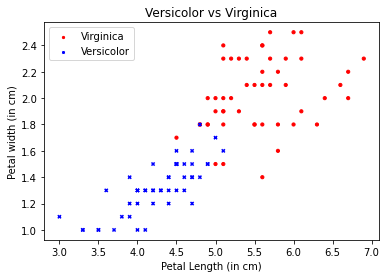

In [5]:
plt.title("Versicolor vs Virginica")
plt.xlabel('Petal Length (in cm)')
plt.ylabel("Petal width (in cm)")
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1-y_svm), marker='o', color = 'r', label = 'Virginica')
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1+y_svm), marker='x', color = 'b', label = 'Versicolor')
plt.legend(loc='upper left')
plt.show()

In [14]:
#coding soft svm: with the weight to the slack variable being C
def learn_SVM(X, y, C):
  w = 0
  b = 0
  #label (+1/-1)  
  y_diag = np.diag(y.squeeze())
  #G = X_t X_t^T
  X_tilde = y_diag @ X
  #in case it is psd it takes approximate eigenvalues (i.e. if it has eigenvalues = true)
  G = optimizer.Parameter(shape=(y.shape[0], y.shape[0]), value=X_tilde @ X_tilde.T, PSD=True)


  one_vector = np.ones(shape=y.shape)
  
  #alpha (dual variable)
  alpha = optimizer.Variable(y.shape)
  #quad_form -> alpha^T G alpha
  L =  one_vector.T @ alpha - 0.5 * optimizer.quad_form(alpha, G)
  #equality, inequalities are considered element wise
  optim_prob = optimizer.Problem(optimizer.Maximize(L), constraints=[alpha <= C, alpha >= 0, alpha.T @ y == 0])
  
  optim_prob.solve(solver=optimizer.OSQP)

  w = X_tilde.T @ (alpha.value)
  #always true (irrespective of hard/soft svm)
  #find an 0 < alpha_n < C
  index = 0
  for i in range(len(y)):
    #support vectors where C > alpha_n > 0
    if ~np.isclose(alpha[i, 0].value, 0) and ~np.isclose(alpha[i, 0].value, C):
      index = i
      break
  #yn - w^T xn
  b = y[index, 0] - ((X[index, :].reshape(1, X.shape[1])) @ w)
  return w.squeeze(), b.squeeze()

In [15]:
C = 10
w, b = learn_SVM(X_svm, y_svm, C)
print(w, b)

[-2.75862069 -4.82758621] 21.206896551724192


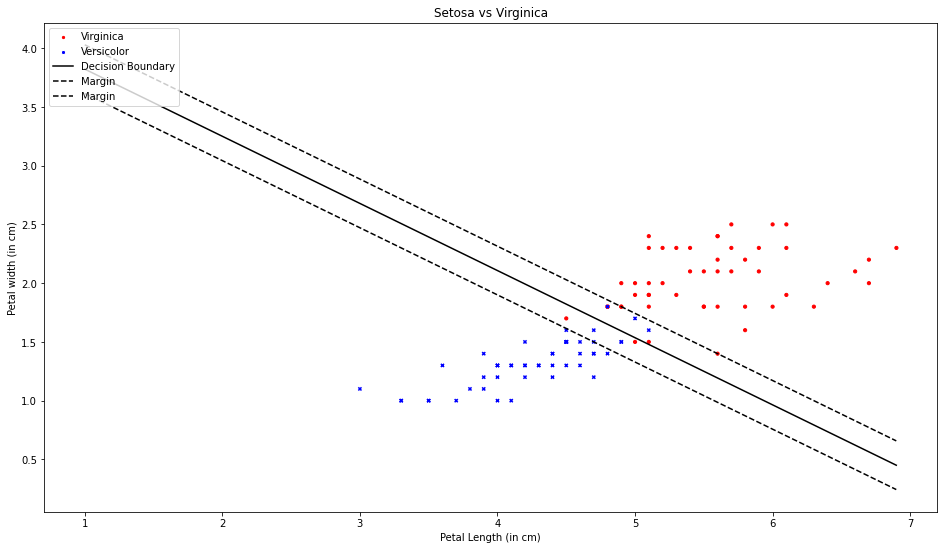

In [16]:
#plot scatter
plt.figure(figsize=(16, 9))
plt.title("Setosa vs Virginica")
plt.xlabel('Petal Length (in cm)')
plt.ylabel("Petal width (in cm)")
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1-y_svm), marker='o', color = 'r', label = 'Virginica')
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1+y_svm), marker='x', color = 'b', label = 'Versicolor')

#plot line
m =  -w[0]/w[1]
c = -b/w[1]
path = 1/w[1]

x_l = np.arange(np.min(X[:, 0]), np.max(X[:, 0]), 1E-3)
y_l = m*x_l + c
plt.plot(x_l, y_l, color=[0,0,0], ls='-', label='Decision Boundary')
#w1x1 + w2x2 + b = 1 => x2 = -w1/w2 x1 -b/w2 + 1/w2
y_l_p = m*x_l + c + path
y_l_n = m*x_l + c - path
plt.plot(x_l, y_l_p, color=[0,0,0], ls='--', label='Margin')
plt.plot(x_l, y_l_n, color=[0,0,0], ls='--', label='Margin')
plt.legend(loc='upper left')
plt.show()

# Hard SVM

In [22]:
#putting C to be very large - not allow much slackness
w, b = learn_SVM(X_svm, y_svm, 200)
print(w, b)

[-3.99782278 -7.9962232 ] 30.984479554626205


C:\Users\ASUS\anaconda3\envs\deep_learning\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


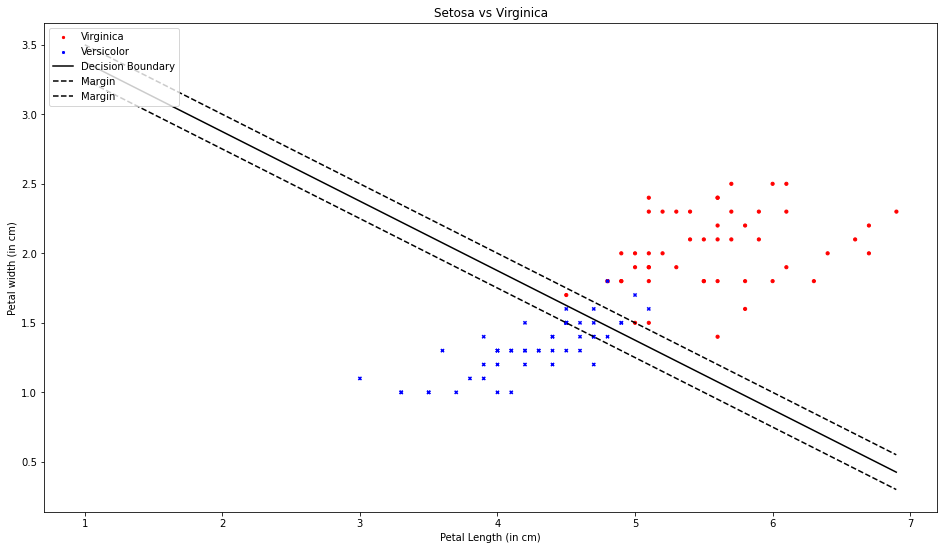

In [23]:
#plot scatter
plt.figure(figsize=(16, 9))
plt.title("Setosa vs Virginica")
plt.xlabel('Petal Length (in cm)')
plt.ylabel("Petal width (in cm)")
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1-y_svm), marker='o', color = 'r', label = 'Virginica')
plt.scatter(X_svm[:, 0], X_svm[:, 1], s=5*(1+y_svm), marker='x', color = 'b', label = 'Versicolor')

#plot line
m =  -w[0]/w[1]
c = -b/w[1]
path = 1/w[1]

x_l = np.arange(np.min(X[:, 0]), np.max(X[:, 0]), 1E-3)
y_l = m*x_l + c
plt.plot(x_l, y_l, color=[0,0,0], ls='-', label='Decision Boundary')
#w1x1 + w2x2 + b = 1 => x2 = -w1/w2 x1 -b/w2 + 1/w2
y_l_p = m*x_l + c + path
y_l_n = m*x_l + c - path
plt.plot(x_l, y_l_p, color=[0,0,0], ls='--', label='Margin')
plt.plot(x_l, y_l_n, color=[0,0,0], ls='--', label='Margin')
plt.legend(loc='upper left')
plt.show()

In [24]:
#putting C to be very large - not allow much slackness
w, b = learn_SVM(X_svm, y_svm, 2000)
print(w, b)

C:\Users\ASUS\anaconda3\envs\deep_learning\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.